In [ ]:
from google.colab import files
files.upload()

Saving kaggle (3).json to kaggle (3).json


{'kaggle (3).json': b'{"username":"vliqubadov","key":"53c32b9b3b40c820299503b26599c850"}'}

In [ ]:
import os
import shutil

os.makedirs("/root/.kaggle", exist_ok=True)
shutil.move("kaggle (3).json", "/root/.kaggle/kaggle.json")
os.chmod("/root/.kaggle/kaggle.json", 0o600)

#Data loading and preprocessing

In [ ]:
!kaggle datasets download xhlulu/140k-real-and-fake-faces

Dataset URL: https://www.kaggle.com/datasets/xhlulu/140k-real-and-fake-faces
License(s): other
 98% 3.67G/3.75G [00:54<00:05, 16.8MB/s]
100% 3.75G/3.75G [00:54<00:00, 73.4MB/s]


In [ ]:
import zipfile

zip_f=zipfile.ZipFile('/content/140k-real-and-fake-faces.zip')
zip_f.extractall()
zip_f.close()

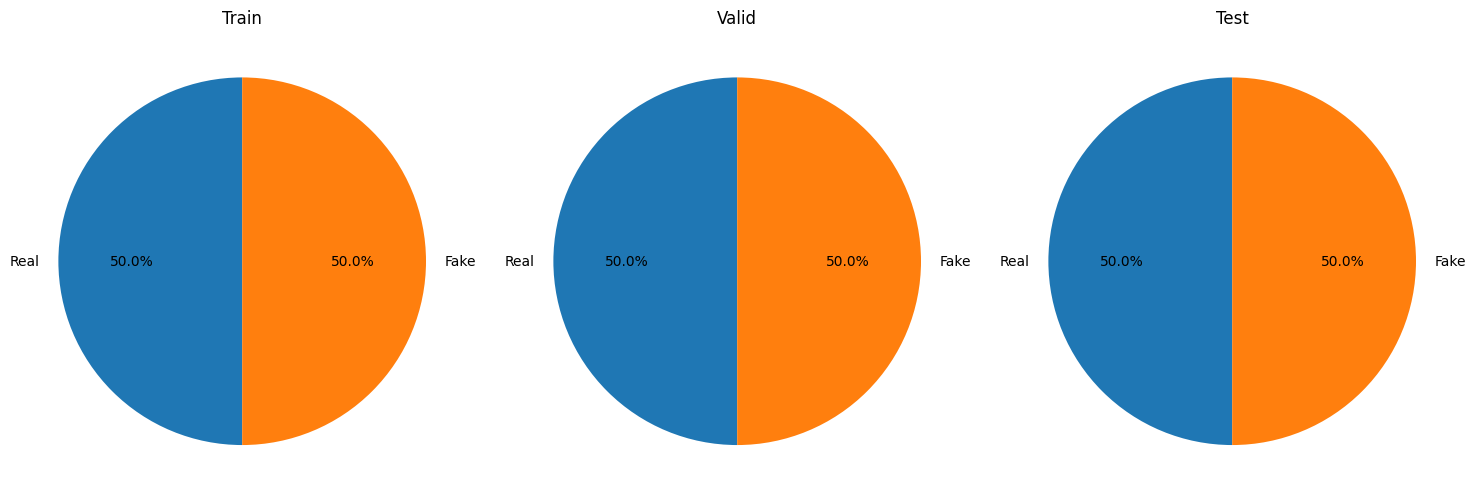

In [ ]:
import os
import matplotlib.pyplot as plt

dataset_dir = "/content/real_vs_fake/real-vs-fake"
subsets = ['train', 'valid', 'test']

plt.figure(figsize=(15, 5))

for i, subset in enumerate(subsets):
    real_dir = os.path.join(dataset_dir, subset, 'real')
    fake_dir = os.path.join(dataset_dir, subset, 'fake')

    real_count = len(os.listdir(real_dir))
    fake_count = len(os.listdir(fake_dir))

    labels = ['Real', 'Fake']
    sizes = [real_count, fake_count]

    plt.subplot(1, 3, i + 1)
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
    plt.title(f"{subset.capitalize()}")

plt.tight_layout()
plt.show()


In [ ]:
import random
from PIL import Image

def show_random_image(image_dir, title="Image"):
    image_list = os.listdir(image_dir)
    image_path = os.path.join(image_dir, random.choice(image_list))
    img = Image.open(image_path)
    plt.imshow(img)
    plt.title(title)
    plt.axis("off")
    plt.show()


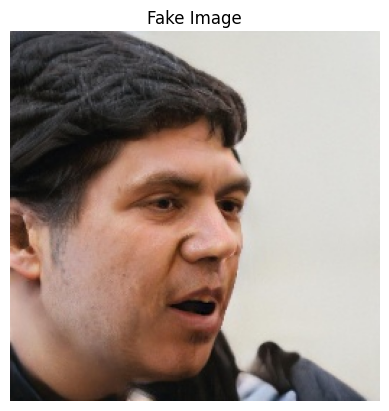

In [ ]:
show_random_image("/content/real_vs_fake/real-vs-fake/train/fake", "Fake Image")

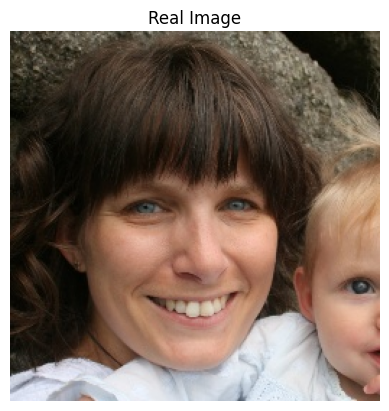

In [ ]:
show_random_image("/content/real_vs_fake/real-vs-fake/train/real", "Real Image")

#Data Augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True,
)

val_test_datagen =ImageDataGenerator(rescale=1./255)
test_datagen=ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    directory='/content/real_vs_fake/real-vs-fake/train',
    target_size=(224,224),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_test_datagen.flow_from_directory(
    directory='/content/real_vs_fake/real-vs-fake/valid',
    target_size=(224,224),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    directory='/content/real_vs_fake/real-vs-fake/test',
    target_size=(224,224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


#ResNet50


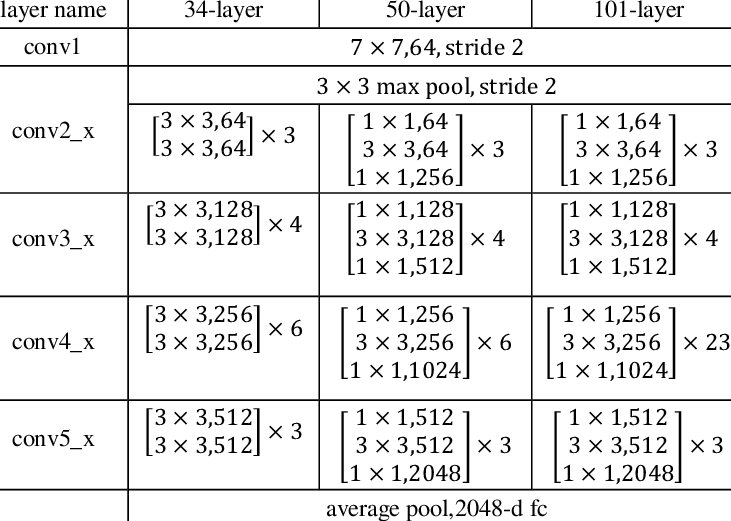

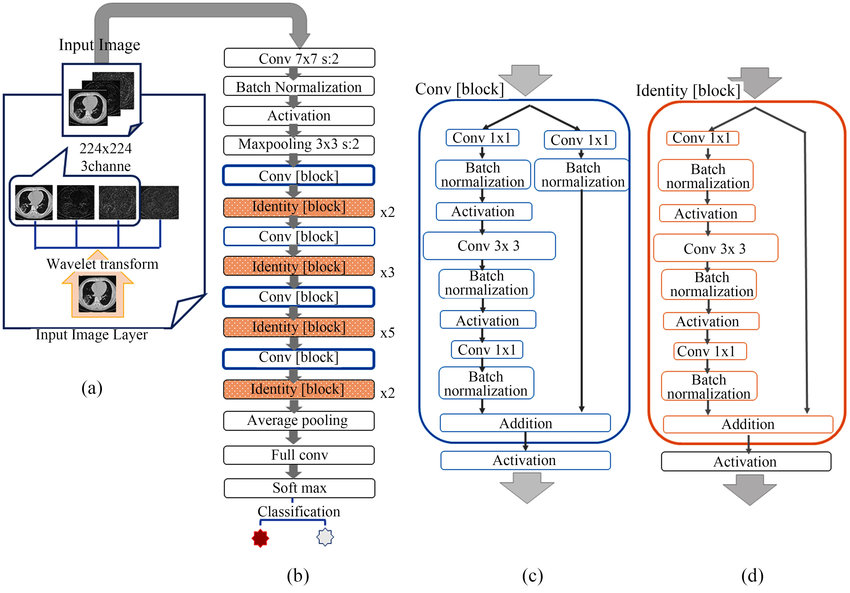

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers,regularizers
from tensorflow.keras.layers import Conv2D,Activation,Add,BatchNormalization,MaxPooling2D,AveragePooling2D,Dropout

def blocks(x,filters,stride=1,conv_block=False):
    x_2=x
    x=layers.Conv2D(filters=filters,kernel_size=1,strides=stride,
                    padding='same',kernel_regularizer=regularizers.l2(1e-4),
                    kernel_initializer='he_normal',use_bias=False)(x)
    x=BatchNormalization()(x)
    x=layers.Activation('relu')(x)
    x=layers.Conv2D(filters=filters,kernel_size=3,strides=1,
                    padding='same',kernel_regularizer=regularizers.l2(1e-4),
                    kernel_initializer='he_normal',use_bias=False)(x)
    x=BatchNormalization()(x)
    x=layers.Activation('relu')(x)
    x=layers.Conv2D(filters=4*filters,kernel_size=1,strides=1,
                    padding='same',kernel_regularizer=regularizers.l2(1e-4),
                    kernel_initializer='he_normal',use_bias=False)(x)
    x=BatchNormalization()(x)
    if conv_block==True:
        x_2=layers.Conv2D(filters=4*filters,kernel_size=1,strides=stride,
                          padding='same',kernel_regularizer=regularizers.l2(1e-4),
                          kernel_initializer='he_normal',use_bias=False)(x_2)
        x_2=BatchNormalization()(x_2)
    x = Add()([x_2, x])
    added=layers.Activation('relu')(x)
    return added


In [ ]:
inputs = tf.keras.layers.Input(shape=(224, 224, 3))
x =tf.keras.layers.Conv2D(filters=64, kernel_size=7, strides=2,
                          padding='same',kernel_regularizer=regularizers.l2(1e-4),
                          kernel_initializer='he_normal', activation='relu',use_bias=False)(inputs)
x=BatchNormalization()(x)
x=layers.Activation('relu')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=3, strides=2,padding='same')(x)

#conv2_x
x=blocks(x,64,stride=1,conv_block=True)
for i in range(2):
    x=blocks(x,64,stride=1,conv_block=False)

#conv3_x
x=blocks(x,128,stride=2,conv_block=True)
for i in range(3):
    x=blocks(x,128,stride=1,conv_block=False)

#conv4_x
x=blocks(x,256,stride=2,conv_block=True)
for i in range(5):
    x=blocks(x,256,stride=1,conv_block=False)

#conv5_x
x=blocks(x,512,stride=2,conv_block=True)
for i in range(2):
    x=blocks(x,512,stride=1,conv_block=False)

x= layers.GlobalAveragePooling2D()(x)
x = Dropout(0.6)(x)
outputs= layers.Dense(1, activation='sigmoid',kernel_regularizer=regularizers.l2(1e-4))(x)
model1 = tf.keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model1.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy','auc','recall','precision']
)


In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_baseline_model.keras',
    save_best_only=True
)

In [ ]:
history1 = model1.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[early_stop,checkpoint]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1625s 502ms/step - accuracy: 0.5797 - auc: 0.6024 - loss: 5.8566 - precision: 0.5810 - recall: 0.5733 - val_accuracy: 0.6970 - val_auc: 0.7718 - val_loss: 4.5199 - val_precision: 0.6679 - val_recall: 0.7834
Epoch 2/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1532s 490ms/step - accuracy: 0.7238 - auc: 0.7930 - loss: 4.0370 - precision: 0.7205 - recall: 0.7318 - val_accuracy: 0.7778 - val_auc: 0.8581 - val_loss: 2.8314 - val_precision: 0.7840 - val_recall: 0.7668
Epoch 3/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1507s 482ms/step - accuracy: 0.7980 - auc: 0.8781 - loss: 2.5191 - precision: 0.7940 - recall: 0.8054 - val_accuracy: 0.8360 - val_auc: 0.9181 - val_loss: 1.8696 - val_precision: 0.8050 - val_recall: 0.8869
Epoch 4/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1514s 484ms/step - accuracy: 0.8435 - auc: 0.9205 - loss: 1.7429 - precision: 0.8389 - recall: 0.8500 - val_accuracy: 0.7777 - val_auc: 0.9288 - val_loss: 1.6041 - val_precision: 0.7011 - val_recall: 0.9683
Epoc

Epoch 1/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1625s 502ms/step - accuracy: 0.5797 - auc: 0.6024 - loss: 5.8566 - precision: 0.5810 - recall: 0.5733 - val_accuracy: 0.6970 - val_auc: 0.7718 - val_loss: 4.5199 - val_precision: 0.6679 - val_recall: 0.7834

Epoch 2/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1532s 490ms/step - accuracy: 0.7238 - auc: 0.7930 - loss: 4.0370 - precision: 0.7205 - recall: 0.7318 - val_accuracy: 0.7778 - val_auc: 0.8581 - val_loss: 2.8314 - val_precision: 0.7840 - val_recall: 0.7668

Epoch 3/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1507s 482ms/step - accuracy: 0.7980 - auc: 0.8781 - loss: 2.5191 - precision: 0.7940 - recall: 0.8054 - val_accuracy: 0.8360 - val_auc: 0.9181 - val_loss: 1.8696 - val_precision: 0.8050 - val_recall: 0.8869

Epoch 4/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1514s 484ms/step - accuracy: 0.8435 - auc: 0.9205 - loss: 1.7429 - precision: 0.8389 - recall: 0.8500 - val_accuracy: 0.7777 - val_auc: 0.9288 - val_loss: 1.6041 - val_precision: 0.7011 - val_recall: 0.9683

Epoch 5/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1526s 488ms/step - accuracy: 0.8730 - auc: 0.9445 - loss: 1.3616 - precision: 0.8692 - recall: 0.8785 - val_accuracy: 0.7882 - val_auc: 0.9384 - val_loss: 1.5162 - val_precision: 0.9573 - val_recall: 0.6033

Epoch 6/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1547s 495ms/step - accuracy: 0.8932 - auc: 0.9603 - loss: 1.1492 - precision: 0.8891 - recall: 0.8970 - val_accuracy: 0.8435 - val_auc: 0.9551 - val_loss: 1.1828 - val_precision: 0.7740 - val_recall: 0.9704

Epoch 7/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1498s 479ms/step - accuracy: 0.9102 - auc: 0.9701 - loss: 1.0148 - precision: 0.9071 - recall: 0.9131 - val_accuracy: 0.8754 - val_auc: 0.9633 - val_loss: 1.0379 - val_precision: 0.8163 - val_recall: 0.9689

Epoch 8/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1505s 482ms/step - accuracy: 0.9214 - auc: 0.9766 - loss: 0.9185 - precision: 0.9194 - recall: 0.9242 - val_accuracy: 0.7969 - val_auc: 0.9456 - val_loss: 1.3816 - val_precision: 0.9809 - val_recall: 0.6056

Epoch 9/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1591s 509ms/step - accuracy: 0.9294 - auc: 0.9811 - loss: 0.8440 - precision: 0.9247 - recall: 0.9348 - val_accuracy: 0.8913 - val_auc: 0.9576 - val_loss: 0.9004 - val_precision: 0.8854 - val_recall: 0.8988

Epoch 10/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1538s 492ms/step - accuracy: 0.9370 - auc: 0.9837 - loss: 0.7848 - precision: 0.9343 - recall: 0.9407 - val_accuracy: 0.9123 - val_auc: 0.9736 - val_loss: 0.8032 - val_precision: 0.8937 - val_recall: 0.9359

In [ ]:
model1.save('rmodel.keras')

In [ ]:
from tensorflow.keras.models import load_model

model1 = load_model("/content/rmodel.keras")

In [ ]:
model1.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 112, 112,  │      9,408 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 112, 112,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 56, 56,    │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 56, 56,    │      4,096 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 56, 56,    │     36,864 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 56, 56,    │     16,384 │ max_pooling2d[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 56, 56,    │     16,384 │ activation_2[0][… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │      1,024 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │      1,024 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 256)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 56, 56,    │          0 │ add[0][0]       

 Total params: 70,583,365 (269.25 MB)

 Trainable params: 23,510,081 (89.68 MB)

 Non-trainable params: 53,120 (207.50 KB)

 Optimizer params: 47,020,164 (179.37 MB)

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model1,show_layer_names=True)


In [ ]:
scores = model1.evaluate(test_generator,return_dict=True, verbose=0)
print(scores)
print(f"Accuracy: {scores['accuracy']}")
print(f"Loss: {scores['loss']}")
print(f"AUC: {scores['auc']}")
print(f"Precision: {scores['precision']}")
print(f"Recall: {scores['recall']}")


{'accuracy': 0.9120500087738037, 'auc': 0.9742730855941772, 'loss': 0.8014851212501526, 'precision': 0.8924659490585327, 'recall': 0.9369999766349792}
Accuracy: 0.9120500087738037
Loss: 0.8014851212501526
AUC: 0.9742730855941772
Precision: 0.8924659490585327
Recall: 0.9369999766349792


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns

In [ ]:
y_pred_proba = model1.predict(test_generator)
y_pred = (y_pred_proba > 0.5).astype(int).reshape(-1)
y_true = test_generator.classes


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


625/625 ━━━━━━━━━━━━━━━━━━━━ 56s 80ms/step


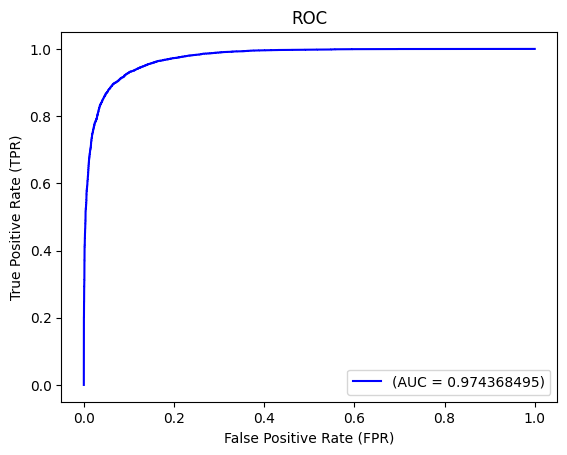

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'(AUC = {auc})')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

In [ ]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
print(f"Precision: {precision}")
print(f"Recall:    {recall}")
print(f"F1 Score:  {f1}")

Precision: 0.8924659491380131
Recall:    0.937
F1 Score:  0.9141909361432266


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_true, y_pred)
cm

array([[8871, 1129],
       [ 630, 9370]])

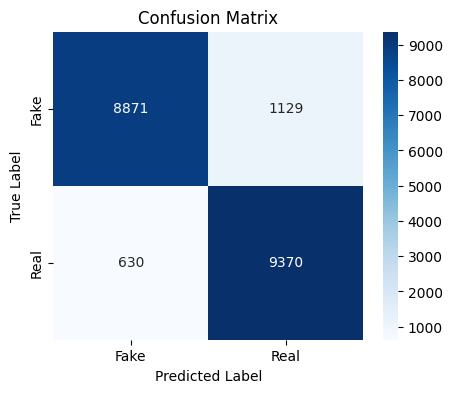

In [ ]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=['Fake', 'Real']))

              precision    recall  f1-score   support

        Fake       0.93      0.89      0.91     10000
        Real       0.89      0.94      0.91     10000

    accuracy                           0.91     20000
   macro avg       0.91      0.91      0.91     20000
weighted avg       0.91      0.91      0.91     20000



#Test

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


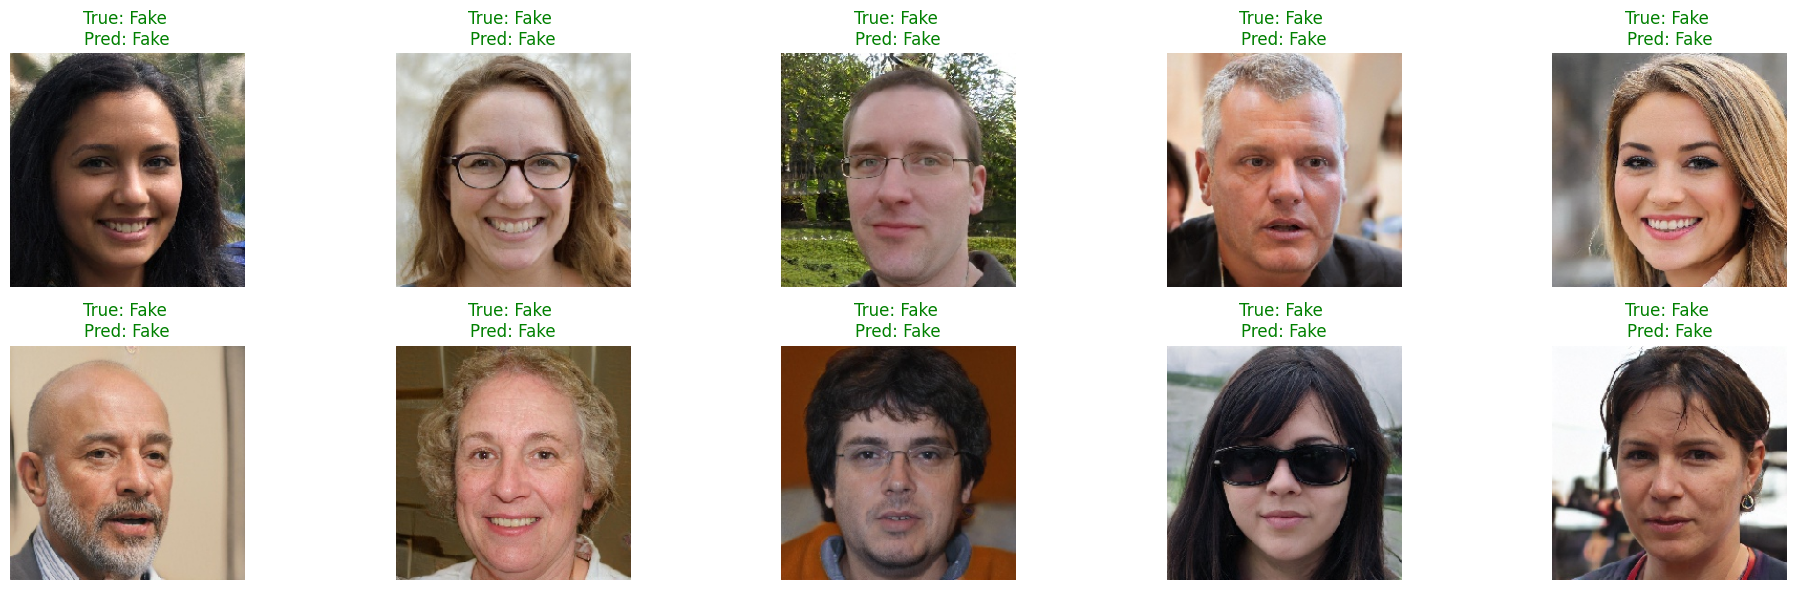

In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

test_fake_dir = "/content/real_vs_fake/real-vs-fake/test/fake"
fake_images = random.sample(os.listdir(test_fake_dir), 10)

images = []
for img_name in fake_images:
    img_path = os.path.join(test_fake_dir, img_name)
    img = load_img(img_path, target_size=(224,224))
    img_array = img_to_array(img) / 255.0
    images.append(img_array)

images_np = np.array(images)
pred_probs = model1.predict(images_np)
preds = (pred_probs > 0.5).astype(int).reshape(-1)
plt.figure(figsize=(20, 6))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(images[i])
    plt.axis('off')

    true_label = 'Fake'
    if preds[i] == 0:
        pred_label = 'Fake'
    else:
        pred_label = 'Real'

    if preds[i] ==0:
        color = 'green'
    else:
        color = 'red'

    plt.title(
        f"True: Fake \nPred: {pred_label}",
        color=color,
    )

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


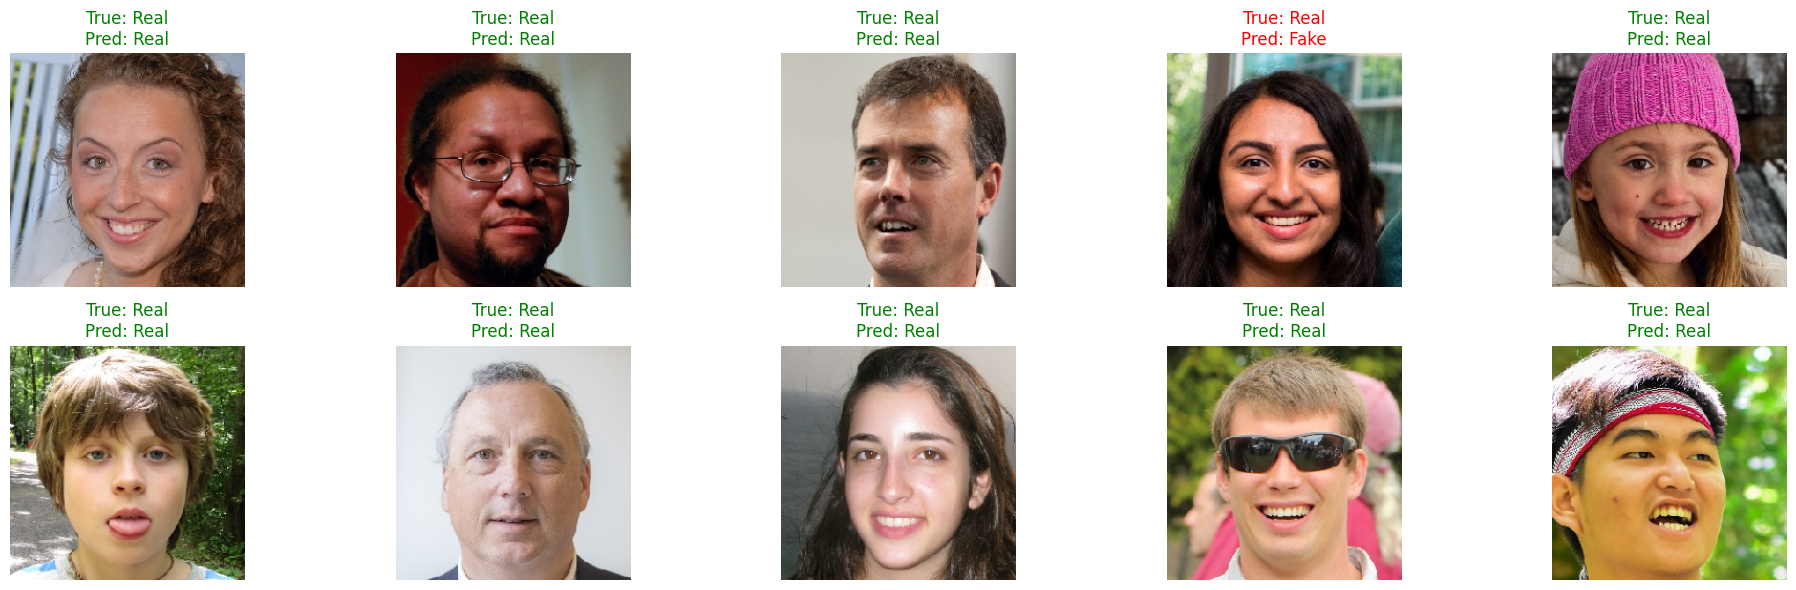

In [ ]:
test_real_dir = "/content/real_vs_fake/real-vs-fake/test/real"
real_images = random.sample(os.listdir(test_real_dir), 10)

images = []

for img_name in real_images:
    img_path = os.path.join(test_real_dir, img_name)
    img = load_img(img_path, target_size=(224,224))
    img_array = img_to_array(img) / 255.0
    images.append(img_array)

images_np = np.array(images)
pred_probs = model1.predict(images_np)
preds = (pred_probs > 0.5).astype(int).reshape(-1)
plt.figure(figsize=(20, 6))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(images[i])
    plt.axis('off')

    true_label = 'Real'
    if preds[i] == 1:
        pred_label = 'Real'
    else:
        pred_label = 'Fake'

    if preds[i] == 1:
        color = 'green'
    else:
        color = 'red'

    plt.title(
        f"True: {true_label}\nPred: {pred_label}",
        color=color
    )

plt.tight_layout()
plt.show()


In [ ]:
preds = (y_pred_proba > 0.5).astype(int).reshape(-1)
preds

array([0, 0, 0, ..., 1, 1, 1])